# This notebook used with blocks that already have a behavioral state annotation (either through video_based_state_annotation.ipynb OR through add_accelerometer_state_annotations.ipynb

In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception(
                'problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i + 1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1,
                             speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[
                          0] - 1  # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind': saccade_on_inds,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind': saccade_off_inds,
                    'saccade_end_timestamp': saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                                   endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)

    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(
        angles) % 360)  # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df[
        'initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df[
        'initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


In [14]:

# define a single block to synchronize and finally export l/r_eye_data csv files:
# this step creates block_collection - a list of BlockSync objects of interest
#animal = 'PV_126'||block_numbers = [7,8,9,10,11,12,13,14]
bad_blocks = [6] # 
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_numbers = [23,24,25,26,27]

block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks,regev=True)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b
block = block_collection[0]

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 025 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_025, new OE version
Found the sample rate for block 025 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 025
got it!
instantiated block number 026 at Path: Z:\Nimrod\experi

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

def aggregate_and_plot_probabilities_multi_blocks(block_list, export_path=None, num_bins=50):
    """
    Generate and save elegant Seaborn-based probability plots for pupil diameter distributions
    across multiple blocks.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}
    
    # Loop through each block to aggregate data
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']
            
            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter'].dropna()
            
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot probabilities for the left eye
    plt.figure(figsize=(3, 2), dpi=100)
    for annotation, data in left_eye_aggregated.items():
        sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True,
                     label=f'Left Eye - {annotation}', alpha=0.7,
                     color=color_map.get(annotation, 'gray'), fill=False)
    plt.title('Left Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot probabilities for the right eye
    plt.figure(figsize=(3, 2), dpi=100)
    for annotation, data in right_eye_aggregated.items():
        sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True,
                     label=f'Right Eye - {annotation}', alpha=0.7,
                     color=color_map.get(annotation, 'gray'), fill=False)
    plt.title('Right Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()

    if export_path is not None:
        pdf_pages.close()

    plt.show()


In [8]:
import pandas as pd

def read_behavior_state(block):
    """
    Reads the behavior_state CSV file from the block's analysis folder and assigns it to the block object.

    Args:
        block (BlockSync): The block object containing metadata about the analysis folder.

    Returns:
        pd.DataFrame: The loaded behavior state dataframe.
    """
    try:
        # Construct the path to the CSV file
        csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
        
        if not csv_path.exists():
            raise FileNotFoundError(f"No behavior_state file found at {csv_path}")
        
        # Read the CSV into a DataFrame
        behavior_state_df = pd.read_csv(csv_path)
        
        # Assign it to the block object for easy access
        block.behavior_state = behavior_state_df
        print(f"Behavior state successfully loaded from {csv_path}")
        
        return behavior_state_df
    
    except Exception as e:
        print(f"Error reading behavior state: {e}")
        return None

def create_distance_plot(distances, top_dist_to_show=500):
    # Create cumulative distribution plot
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, figsize=(6, 6), dpi=150)
    
    axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter', fontsize=15)
    axs[0].set_ylabel('Cumulative \n % of Frames')
    axs[0].set_xlim(0, top_dist_to_show)
    axs[0].grid(False)
    
    # Create histogram and cumulative distribution
    sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
    
    axs[1].hist(distances, bins=np.linspace(0, top_dist_to_show, 20), log=False, color='black')

    # Set title and labels
    title = 'Image displacement histogram'
    axs[1].set_title(title, fontsize=15)
    axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
    axs[1].set_xscale('linear')
    axs[1].set_yscale('linear')
    axs[1].set_ylabel('Frame count', fontsize=15)

    # Adjust tick label sizes
    axs[1].tick_params(axis='x', which='major', labelsize=15)

    # Set white background and black text
    axs[1].set_facecolor('white')
    axs[1].title.set_color('black')
    axs[1].xaxis.label.set_color('black')
    axs[1].yaxis.label.set_color('black')
    axs[1].tick_params(colors='black')
    axs[1].grid(False)

    plt.tight_layout()

    return fig, axs
def add_intermediate_elements(input_vector, gap_to_bridge):
    # Step 1: Calculate differences between each element
    differences = np.diff(input_vector)

    # Step 2: Add intervening elements based on the diff_threshold
    output_vector = [input_vector[0]]
    for i, diff in enumerate(differences):
        if diff < gap_to_bridge:
            # Add intervening elements
            output_vector.extend(range(input_vector[i] + 1, input_vector[i + 1]))

        # Add the next element from the original vector
        output_vector.append(input_vector[i + 1])

    return np.sort(np.unique(output_vector))

def find_jittery_frames(block, eye, max_distance, diff_threshold, gap_to_bridge=6):
    
    #input checks
    if eye not in ['left', 'right']:
        print(f'eye can only be left/right, your input: {eye}')
        return None
    # eye setup
    if eye == 'left':
        jitter_dict = block.le_jitter_dict
        eye_frame_col = 'L_eye_frame'
    elif eye == 'right':
        jitter_dict = block.re_jitter_dict
        eye_frame_col = 'R_eye_frame'
    
    df_dict = {'left':block.le_df,
               'right':block.re_df}
    
    df = pd.DataFrame.from_dict(jitter_dict)
    indices_of_highest_drift = df.query("top_correlation_dist > @max_distance").index.values
    diff_vec = np.diff(df['top_correlation_dist'].values)
    diff_peaks_indices = np.where(diff_vec > diff_threshold)[0]
    video_indices = np.concatenate((diff_peaks_indices, indices_of_highest_drift))
    print(f'the diff based jitter frame exclusion gives: {np.shape(diff_peaks_indices)}')
    print(f'the threshold based jitter frame exclusion gives: {np.shape(indices_of_highest_drift)}')
    
    # creates a bridged version of the overly jittery frames (to contend with single frame outliers)
    video_indices = add_intermediate_elements(video_indices, gap_to_bridge=gap_to_bridge)
    # This is the input you should give to the BlockSync.remove_eye_datapoints function (which already maps it to the df) 
    
    
    # translates the video indices to le/re dataframe rows
    df_indices_to_remove = df_dict[eye].loc[df_dict[eye][eye_frame_col].isin(video_indices)].index.values
    
    return df_indices_to_remove, video_indices

def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    



# Block Instantiation

In [2]:
# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict

#animal = 'PV_62' || block_numbers = [23,24,25,26,27]
#animal = 'PV_126' || block_numbers = [7,8,9,10,11,12,13,14] 
# Example usage:
#animals = ['PV_62','PV_126']
animals = ['PV_57','PV_62','PV_126']
#block_lists = [[23,24,26,27],[7,8,9,10,11,12,13]]
block_lists = [[5,6,7,8,9],[23,24,25,26,27],[7,8,9,10,11,12,13,14]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)

instantiated block number 005 at Path: Z:\Nimrod\experiments\PV_57\2024_11_25\block_005, new OE version
Found the sample rate for block 005 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 005
got it!
instantiated block number 006 at Path: Z:\Nimrod\experiments\PV_57\2024_11_25\block_006, new OE version
Found the sample rate for block 006 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 006
got it!
instantiated block number 007 at Path: Z:\Nimrod\experiments\PV_57\2024_11_25\block_007, new OE version
Found the sample rate for block 007 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 007
got it!
instantiated block number 008 at Path: Z:\Nimrod\experi

In [3]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:

    block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
    block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
    block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 005 has a parsed events file, reading...
Getting eye brightness values for block 005...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 006 has a parsed events file, reading...
Getting eye brightness values for block 006...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 007 has a parsed events file, reading...
Getting eye brightness values for block 007...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [10]:
for block in block_collection:
    #block.block_get_lizard_movement()
    read_behavior_state(block)

Behavior state successfully loaded from Z:\Nimrod\experiments\PV_57\2024_11_25\block_005\analysis\block_005_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_57\2024_11_25\block_006\analysis\block_006_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_57\2024_11_25\block_007\analysis\block_007_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_57\2024_11_25\block_008\analysis\block_008_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_57\2024_11_25\block_009\analysis\block_009_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\analysis\block_023_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\analysis\block_024_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_62\2023_04_27\block_025\analysis\block_025_beh

In [27]:
# saccade detection and annotation: 
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_df(block.left_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.L_pix_size)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_df(block.right_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.R_pix_size)


76it [00:00, 743.82it/s]

PV_57, block 005, on pv_57_day2_01_2024-11-25_14-59-12


265it [00:00, 658.37it/s]
265it [00:00, 742.28it/s]
70it [00:00, 697.75it/s]

PV_57, block 006, on pv_57_day2_02_2024-11-25_15-12-05


359it [00:00, 748.31it/s]
311it [00:00, 769.25it/s]
77it [00:00, 769.57it/s]

PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31


672it [00:00, 768.80it/s]
722it [00:00, 788.27it/s]
79it [00:00, 782.75it/s]

PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18


638it [00:00, 777.09it/s]
599it [00:00, 784.10it/s]
80it [00:00, 791.46it/s]

PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35


502it [00:00, 776.68it/s]
556it [00:00, 781.83it/s]
75it [00:00, 748.05it/s]

PV_62, block 023, on 2023-04-27_10-52-42


602it [00:00, 766.99it/s]
599it [00:00, 770.18it/s]
77it [00:00, 769.80it/s]

PV_62, block 024, on 2023-04-27_11-22-56


602it [00:00, 763.93it/s]
599it [00:00, 781.44it/s]
79it [00:00, 774.73it/s]

PV_62, block 025, on 2023-04-27_11-52-05


585it [00:00, 768.63it/s]
612it [00:00, 780.61it/s]
77it [00:00, 769.82it/s]

PV_62, block 026, on 2023-04-27_12-21-41


598it [00:00, 775.58it/s]
579it [00:00, 757.83it/s]
77it [00:00, 766.72it/s]

PV_62, block 027, on 2023-04-27_12-53-31


721it [00:00, 781.47it/s]
699it [00:00, 776.67it/s]
76it [00:00, 755.10it/s]

PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


1209it [00:01, 749.93it/s]
1180it [00:01, 734.14it/s]
70it [00:00, 686.27it/s]

PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41


366it [00:00, 713.41it/s]
399it [00:00, 698.74it/s]
76it [00:00, 752.25it/s]

PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15


359it [00:00, 741.73it/s]
434it [00:00, 748.15it/s]
75it [00:00, 749.79it/s]

PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57


245it [00:00, 740.18it/s]
288it [00:00, 751.96it/s]
77it [00:00, 762.37it/s]

PV_126, block 011, on PV126_Trial115_eyeTracking_w7


1009it [00:01, 767.24it/s]
1006it [00:01, 763.28it/s]
115it [00:00, 793.10it/s]
0it [00:00, ?it/s]

PV_126, block 012, on PV126_Trial116_eyeTracking_h8


129it [00:00, 767.86it/s]
84it [00:00, 800.01it/s]
0it [00:00, ?it/s]

PV_126, block 013, on PV126_Trial116_eyeTracking_h9


77it [00:00, 793.82it/s]
78it [00:00, 779.81it/s]

PV_126, block 014, on PV126_Trial116_eyeTracking_w9


716it [00:00, 788.49it/s]
629it [00:00, 794.19it/s]


In [30]:
block.left_eye_data.columns

Index(['OE_timestamp', 'eye_frame', 'ms_axis', 'center_x', 'center_y', 'phi',
       'width', 'height', 'major_ax', 'minor_ax', 'ratio',
       'pupil_diameter_pixels', 'pupil_diameter', 'speed_x', 'speed_y',
       'speed_r'],
      dtype='object')

<Figure size 800x600 with 0 Axes>

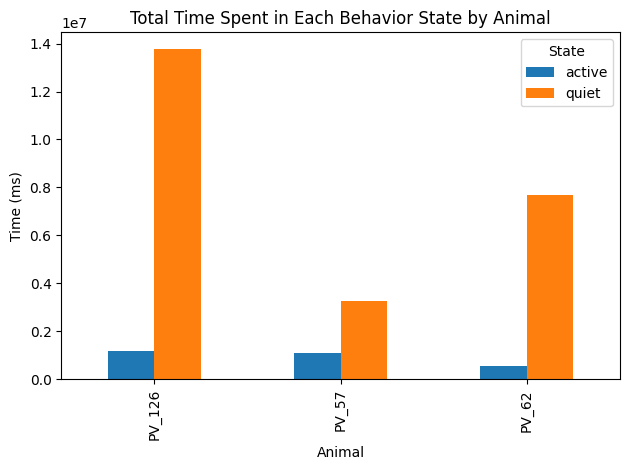

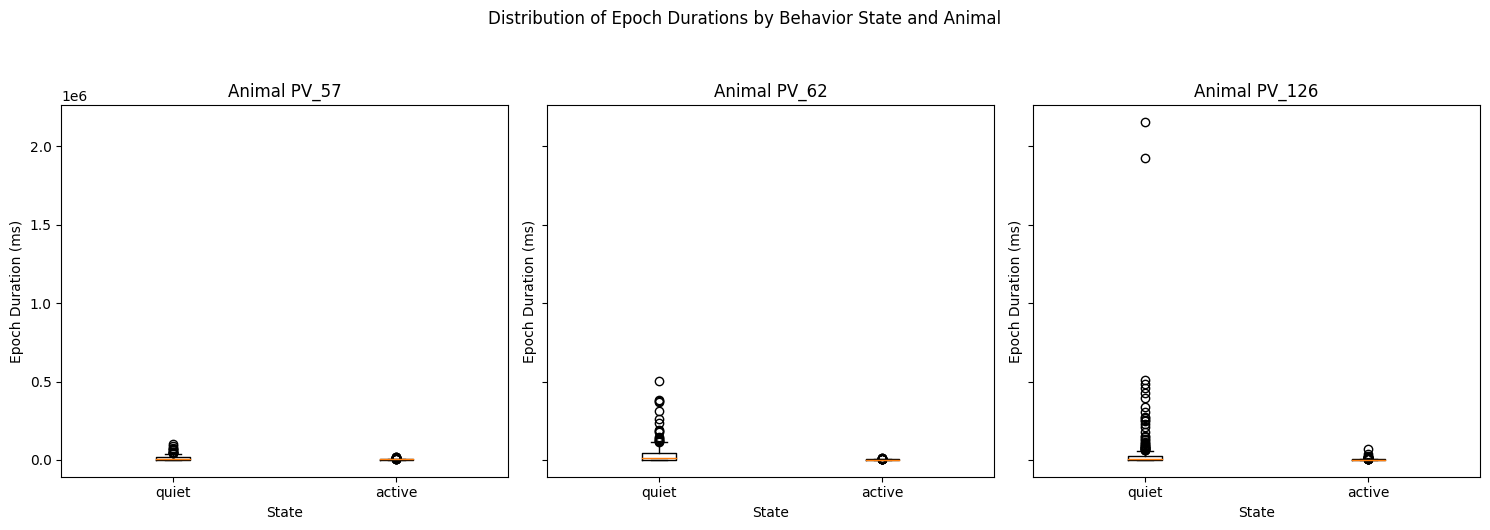

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming block_collection is a list of block objects.
# Each block has:
#   - block.animal: a variable that tells you which animal this block belongs to.
#   - block.state_df: a DataFrame with columns 'start_time', 'end_time', 'annotation'

# Create an empty list to hold the epoch data.
rows = []

# Loop through each block in the collection.
for block in block_collection:
    animal = block.animal_call
    state_df = block.behavior_state  # DataFrame with columns: start_time, end_time, annotation
    # Loop through each epoch/row in the state's DataFrame.
    for _, row in state_df.iterrows():
        state = row['annotation']
        duration = row['end_time'] - row['start_time']
        rows.append({
            'animal': animal,
            'state': state,
            'duration': duration,
            'start_time': row['start_time'],
            'end_time': row['end_time']
        })

# Create a DataFrame with all the epoch information.
df_all = pd.DataFrame(rows)

# Calculate total time per animal and state.
total_time = df_all.groupby(['animal', 'state'])['duration'].sum().unstack()

# -------------------------------
# Plot 1: Bar Plot of Total Time Spent in Each State per Animal
# -------------------------------
plt.figure(figsize=(8, 6))
total_time.plot(kind='bar', stacked=False)
plt.title("Total Time Spent in Each Behavior State by Animal")
plt.ylabel("Time (ms)")
plt.xlabel("Animal")
plt.legend(title="State")
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 2: Box Plot of Epoch Duration Distribution per Animal and State
# -------------------------------
# Identify the unique animals in the dataset.
animals = df_all['animal'].unique()
n_animals = len(animals)

# Create a subplot for each animal.
fig, axs = plt.subplots(1, n_animals, figsize=(5 * n_animals, 5), sharey=True)
if n_animals == 1:
    axs = [axs]  # Ensure axs is iterable if there's only one subplot

for ax, animal in zip(axs, animals):
    # Extract durations for each state (quiet and active) for this animal.
    data_quiet = df_all[(df_all['animal'] == animal) & (df_all['state'] == 'quiet')]['duration']
    data_active = df_all[(df_all['animal'] == animal) & (df_all['state'] == 'active')]['duration']
    
    # Create a box plot for the two states.
    ax.boxplot([data_quiet, data_active], labels=['quiet', 'active'])
    ax.set_title(f"Animal {animal}")
    ax.set_xlabel("State")
    ax.set_ylabel("Epoch Duration (ms)")

plt.suptitle("Distribution of Epoch Durations by Behavior State and Animal", y=1.05)
plt.tight_layout()
plt.show()
import pandas as pd
import matplotlib.pyplot as plt

# Assuming block_collection is a list of block objects.
# Each block has:
#   - block.animal_call: identifier for the animal.
#   - block.behavior_state: DataFrame with columns 'start_time', 'end_time', 'annotation'

# Create an empty list to hold the epoch data.
rows = []

# Loop through each block in the collection.
for block in block_collection:
    animal = block.animal_call
    state_df = block.behavior_state  # DataFrame with columns: start_time, end_time, annotation
    # Loop through each epoch in the state's DataFrame.
    for _, row in state_df.iterrows():
        state = row['annotation']
        duration = row['end_time'] - row['start_time']
        rows.append({
            'animal': animal,
            'state': state,
            'duration': duration,
            'start_time': row['start_time'],
            'end_time': row['end_time']
        })

# Create a DataFrame with all the epoch information.
df_all = pd.DataFrame(rows)

# Calculate total time per animal and state.
total_time = df_all.groupby(['animal', 'state'])['duration'].sum().unstack()

# Compute ratio (quiet/active) for each animal.
total_time['ratio_quiet_active'] = total_time.apply(
    lambda x: x['quiet']/x['active'] if x['active'] != 0 else float('nan'), axis=1
)

print("Total Time Spent (ms) per Animal and State:")
print(total_time)
print("\nRatio of quiet to active time for each animal (quiet/active):")
print(total_time['ratio_quiet_active'])

# Compute descriptive statistics for each animal and state.
summary_stats = df_all.groupby(['animal', 'state'])['duration'].describe()
print("\nDescriptive Statistics for Epoch Durations (ms):")
print(summary_stats)

# -------------------------------
# Plot 1: Bar Plot of Total Time per State for Each Animal
# Each subplot (or the overall plot) is made compact.
# -------------------------------
plt.figure(figsize=(2 * total_time.shape[0], 2))
total_time[['quiet', 'active']].plot(kind='bar', stacked=False)
plt.title("Total Time by State per Animal", fontsize=8)
plt.ylabel("Time (ms)", fontsize=8)
plt.xlabel("Animal", fontsize=8)
plt.legend(title="State", fontsize=6, title_fontsize=6)
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 2: Box Plot of Epoch Duration Distribution per Animal and State
# Each subplot is set to roughly 2x2 inches.
# -------------------------------
animals = df_all['animal'].unique()
n_animals = len(animals)

fig, axs = plt.subplots(1, n_animals, figsize=(2 * n_animals, 2), sharey=True)
if n_animals == 1:
    axs = [axs]  # ensure axs is iterable

for ax, animal in zip(axs, animals):
    data_quiet = df_all[(df_all['animal'] == animal) & (df_all['state'] == 'quiet')]['duration']
    data_active = df_all[(df_all['animal'] == animal) & (df_all['state'] == 'active')]['duration']
    ax.boxplot([data_quiet, data_active], labels=['quiet', 'active'])
    ax.set_title(f"Animal {animal}", fontsize=8)
    ax.set_xlabel("State", fontsize=8)
    ax.set_ylabel("Duration (ms)", fontsize=8)
    ax.tick_params(axis='both', labelsize=6)

plt.suptitle("Epoch Duration Distribution by State", fontsize=10, y=1.05)
plt.tight_layout()
plt.show()

# -------------------------------
# Optional: Histograms for further analysis
# These provide another perspective on the distribution of epoch durations.
# -------------------------------
for animal in animals:
    plt.figure(figsize=(2, 2))
    subset = df_all[df_all['animal'] == animal]
    plt.hist(subset[subset['state']=='quiet']['duration'], alpha=0.5, label='quiet')
    plt.hist(subset[subset['state']=='active']['duration'], alpha=0.5, label='active')
    plt.title(f"Histogram of Epoch Durations: Animal {animal}", fontsize=8)
    plt.xlabel("Duration (ms)", fontsize=8)
    plt.ylabel("Count", fontsize=8)
    plt.legend(fontsize=6)
    plt.tight_layout()
    plt.show()


Quiet/Active Ratio per Animal:
animal
PV_126    11.766866
PV_57      2.957428
PV_62     14.045620
dtype: float64


<Figure size 400x400 with 0 Axes>

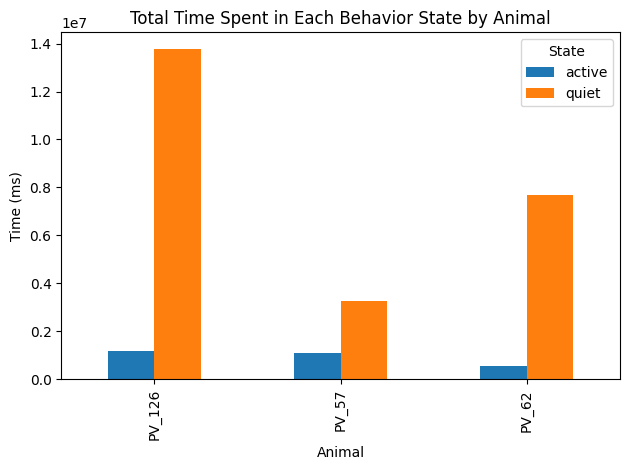

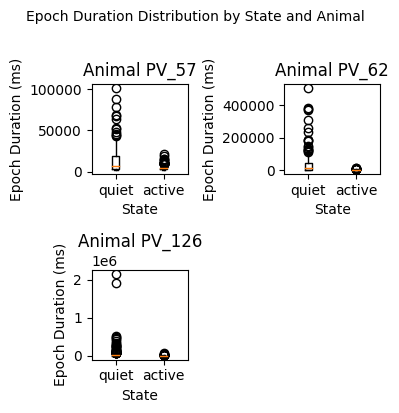

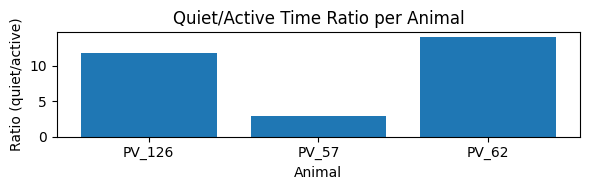

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Data Extraction ---
# Assuming block_collection is a list of block objects.
# Each block has:
#   - block.animal_call: a variable that tells you which animal this block belongs to.
#   - block.behavior_state: a DataFrame with columns 'start_time', 'end_time', 'annotation'

# Create an empty list to hold the epoch data.
rows = []

# Loop through each block in the collection.
for block in block_collection:
    animal = block.animal_call
    state_df = block.behavior_state  # DataFrame with columns: start_time, end_time, annotation
    # Loop through each epoch/row in the state's DataFrame.
    for _, row in state_df.iterrows():
        state = row['annotation']
        duration = row['end_time'] - row['start_time']
        rows.append({
            'animal': animal,
            'state': state,
            'duration': duration,
            'start_time': row['start_time'],
            'end_time': row['end_time']
        })

# Create a DataFrame with all the epoch information.
df_all = pd.DataFrame(rows)

# --- Total Time and Ratio Calculation ---
# Calculate total time per animal and state.
total_time = df_all.groupby(['animal', 'state'])['duration'].sum().unstack()

# Calculate the ratio between quiet and active times for every animal.
# (quiet/active)
ratio_series = total_time['quiet'] / total_time['active']
print("Quiet/Active Ratio per Animal:")
print(ratio_series)

# --- Plot 1: Bar Plot of Total Time ---
plt.figure(figsize=(4, 4))  # Smaller overall figure
total_time.plot(kind='bar', stacked=False)
plt.title("Total Time Spent in Each Behavior State by Animal")
plt.xlabel("Animal")
plt.ylabel("Time (ms)")
plt.legend(title="State")
plt.tight_layout()
plt.show()

# --- Plot 2: Box Plot of Epoch Durations ---
# Identify unique animals.
animals = df_all['animal'].unique()
n_animals = len(animals)

# Create a 2x2 grid of subplots (each subplot ~2x2 inches).
fig, axs = plt.subplots(2, 2, figsize=(4, 4))
axs = axs.flatten()

for i, animal in enumerate(animals):
    ax = axs[i]
    # Extract epoch durations for quiet and active states for the current animal.
    data_quiet = df_all[(df_all['animal'] == animal) & (df_all['state'] == 'quiet')]['duration']
    data_active = df_all[(df_all['animal'] == animal) & (df_all['state'] == 'active')]['duration']
    ax.boxplot([data_quiet, data_active], labels=['quiet', 'active'])
    ax.set_title(f"Animal {animal}")
    ax.set_xlabel("State")
    ax.set_ylabel("Epoch Duration (ms)")

# Turn off any unused subplots.
for j in range(n_animals, len(axs)):
    axs[j].axis('off')

plt.suptitle("Epoch Duration Distribution by State and Animal", y=1.02, fontsize=10)
plt.tight_layout()
plt.show()

# --- Plot 3: Bar Plot for Quiet/Active Ratio ---
# Create a figure where each animal gets roughly a 2-inch-wide space.
plt.figure(figsize=(n_animals * 2, 2))
plt.bar(ratio_series.index, ratio_series.values)
plt.title("Quiet/Active Time Ratio per Animal")
plt.xlabel("Animal")
plt.ylabel("Ratio (quiet/active)")
plt.tight_layout()
plt.show()


PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_126, block 013, on PV126_Trial116_eyeTracking_h9
PV_126, block 014, on PV126_Trial116_eyeTracking_w9


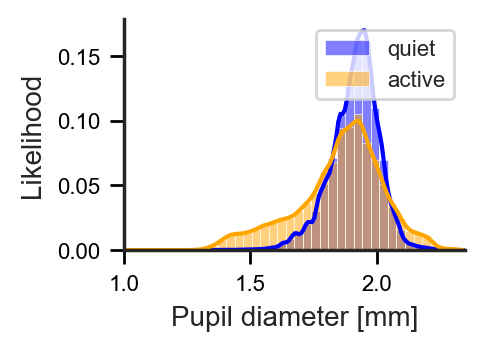

In [44]:
import os
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs
def plot_combined_eye_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Combines left and right eye
    data for each annotation into a single curve. Outputs results into a timestamped folder.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the output (folder created automatically if None is provided).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    combined_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        print(block)
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data.query('speed_r < 4')
        right_eye_data = block.right_eye_data.query('speed_r < 4')

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in combined_aggregated:
                combined_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            # Combine data from both eyes
            combined_aggregated[annotation].extend(left_eye_values)
            combined_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot combined data for all annotations
    fig, ax = plt.subplots(figsize=(2.2, 1.5), dpi=200)
    for annotation, data in combined_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True,
            ax=ax,
        )
    #ax.set_title('Combined Eye Probability Histograms', fontsize=12)
    ax.set_xlabel('Pupil diameter [mm]', fontsize=10)
    ax.set_ylabel('Likelihood', fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', direction='out', which='major',length=5, width=1, colors='black', bottom=True, left=True)
    ax.tick_params(axis='both', direction='out', which='minor', length=5, width=1,colors='black', bottom=True, left=True)
    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)

    # Export section
    if export_path is not None:
        # Create timestamped folder
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_by_behavior_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "pupil_diameter_by_behavior.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save raw data
        data_file = os.path.join(full_export_path, "combined_aggregated_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(combined_aggregated, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_pv62'
plot_combined_eye_probability_histograms(block_collection[11:], export_path=None, num_bins=40, x_range=(1.0, 2.35))

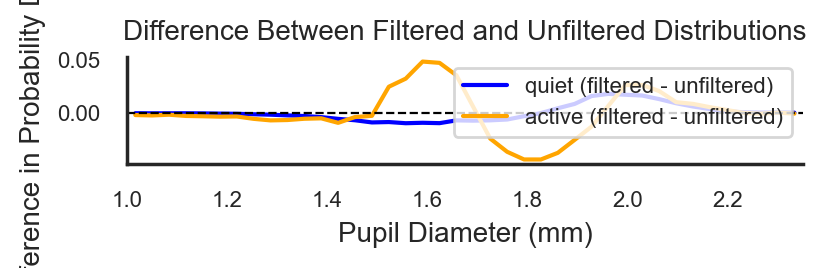

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os


def plot_difference_between_filtered_unfiltered(block_collection, export_path=None, figsize=(2, 1.5),
                                                num_bins=40, x_range=(1.0, 2.35),
                                                outlier_percentiles=(0.001, 99.999), speed_threshold=4):
    """
    Computes and plots the difference between the pupil diameter distributions (filtered minus unfiltered)
    for the 'quiet' and 'active' behavioral states. Optionally exports the figure to a PDF.
    
    Parameters:
        block_collection (list): List of blocks with attributes 'behavior_state', 'left_eye_data', and 'right_eye_data'.
        export_path (str or None): Directory path to export the plot. If provided, a timestamped folder is created.
        figsize (tuple): Figure size (width, height) for the plot.
        num_bins (int): Number of bins to use for the histogram.
        x_range (tuple): The x-axis range for pupil diameters.
        outlier_percentiles (tuple): Percentile range for outlier removal.
        speed_threshold (float): The threshold for filtering high-speed frames (frames with speed_r >= threshold are removed).
    """
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Initialize dictionaries for aggregated data
    aggregated_all = {'quiet': [], 'active': []}
    aggregated_filtered = {'quiet': [], 'active': []}
    all_data_all = []

    # Aggregate data over blocks (both eyes combined)
    for block in block_collection:
        behavior_df = block.behavior_state.copy()
        # Use times as in your notebook
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Unfiltered eye data
        left_all = block.left_eye_data
        right_all = block.right_eye_data
        # Filtered eye data (speed_r below threshold)
        left_filtered = block.left_eye_data.query('speed_r < @speed_threshold')
        right_filtered = block.right_eye_data.query('speed_r < @speed_threshold')

        for _, row in behavior_df.iterrows():
            annotation = row['annotation']
            if annotation not in ['quiet', 'active']:
                continue
            start_ms = row['start_time_ms']
            end_ms = row['end_time_ms']

            # Unfiltered values
            left_vals_all = left_all.query('ms_axis > @start_ms and ms_axis < @end_ms')[
                'pupil_diameter'].dropna().tolist()
            right_vals_all = right_all.query('ms_axis >= @start_ms and ms_axis <= @end_ms')[
                'pupil_diameter'].dropna().tolist()
            aggregated_all[annotation].extend(left_vals_all)
            aggregated_all[annotation].extend(right_vals_all)
            all_data_all.extend(left_vals_all)
            all_data_all.extend(right_vals_all)

            # Filtered values
            left_vals_filt = left_filtered.query('ms_axis > @start_ms and ms_axis < @end_ms')[
                'pupil_diameter'].dropna().tolist()
            right_vals_filt = right_filtered.query('ms_axis >= @start_ms and ms_axis <= @end_ms')[
                'pupil_diameter'].dropna().tolist()
            aggregated_filtered[annotation].extend(left_vals_filt)
            aggregated_filtered[annotation].extend(right_vals_filt)

    # Determine shared bin edges based on overall unfiltered data
    outlier_min_all, outlier_max_all = np.percentile(all_data_all, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min_all, x_range[0]), min(outlier_max_all, x_range[1]), num_bins + 1)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Compute histograms (PDFs) for each annotation using the shared bin edges
    difference_data = {}
    for annotation in ['quiet', 'active']:
        data_unfiltered = [val for val in aggregated_all[annotation] if outlier_min_all <= val <= outlier_max_all]
        data_filtered = [val for val in aggregated_filtered[annotation] if outlier_min_all <= val <= outlier_max_all]
        hist_unfiltered, _ = np.histogram(data_unfiltered, bins=bin_edges, density=True)
        hist_filtered, _ = np.histogram(data_filtered, bins=bin_edges, density=True)
        # Compute the difference (filtered minus unfiltered)
        diff = hist_filtered - hist_unfiltered
        difference_data[annotation] = diff

    # Plot the differences on a single plot
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=figsize, dpi=200)
    for annotation in ['quiet', 'active']:
        ax.plot(bin_midpoints, difference_data[annotation], linestyle='-',
                color=color_map.get(annotation, 'gray'),
                label=f"{annotation} (filtered - unfiltered)")

    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax.set_ylabel('Difference in Probability Density', fontsize=10)
    ax.set_title('Difference Between Filtered and Unfiltered Distributions', fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()

    # Export the figure if an export path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_diff_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        file_path = os.path.join(full_export_path, "pupil_diameter_diff.pdf")
        fig.savefig(file_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Exported plot to: {file_path}")

    plt.show()


plot_difference_between_filtered_unfiltered(block_collection,
                                            export_path=None,
                                            figsize=(4.4, 1.5))

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import math


def plot_difference_by_animal(block_collection, export_path=None, figsize=(6, 4), num_bins=40,
                              x_range=(1.0, 2.35), outlier_percentiles=(0.001, 99.999), speed_threshold=4):
    """
    Groups blocks by animal and plots, for each animal in a separate subplot, 
    two lines (quiet and active) showing the difference (filtered minus unfiltered)
    in the pupil diameter probability density. Each line is drawn with markers,
    so that only the animal’s own computed datapoints (per bin) are displayed.
    
    Parameters:
        block_collection (list): List of block objects with attributes:
            - behavior_state: DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data, right_eye_data: DataFrames with 'ms_axis', 'pupil_diameter', and 'speed_r'.
            - animal: A string identifier for the animal.
        export_path (str or None): If provided, the figure is saved as a PDF in a timestamped folder.
        figsize (tuple): Overall figure size (width, height) for the entire figure.
        num_bins (int): Number of bins for histogram computation.
        x_range (tuple): Range of pupil diameters to consider for the x-axis.
        outlier_percentiles (tuple): Percentile range to determine bin edges from unfiltered data.
        speed_threshold (float): Frames with speed_r >= threshold are filtered out.
    """
    # Group blocks by animal.
    animal_blocks = {}
    for block in block_collection:
        animal = block.animal if hasattr(block, 'animal') else "Unknown"
        if animal not in animal_blocks:
            animal_blocks[animal] = []
        animal_blocks[animal].append(block)

    animals = sorted(animal_blocks.keys())

    # Determine subplot layout: Use 2 columns if more than one animal.
    ncols = 2 if len(animals) > 1 else 1
    nrows = math.ceil(len(animals) / ncols)

    color_map = {'quiet': 'blue', 'active': 'orange'}

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, dpi=200, squeeze=False)

    # Loop over each animal.
    for i, animal in enumerate(animals):
        # Initialize aggregated data for this animal.
        aggregated_all = {'quiet': [], 'active': []}
        aggregated_filtered = {'quiet': [], 'active': []}
        all_data_all = []

        # Process each block for the current animal.
        for block in animal_blocks[animal]:
            behavior_df = block.behavior_state.copy()
            # Use times as in your notebook
            behavior_df['start_time_ms'] = behavior_df['start_time']
            behavior_df['end_time_ms'] = behavior_df['end_time']
            # Unfiltered data.
            left_all = block.left_eye_data
            right_all = block.right_eye_data
            # Filtered data.
            left_filtered = block.left_eye_data.query('speed_r < @speed_threshold')
            right_filtered = block.right_eye_data.query('speed_r < @speed_threshold')

            for _, row in behavior_df.iterrows():
                annotation = row['annotation']
                if annotation not in ['quiet', 'active']:
                    continue
                start_ms = row['start_time_ms']
                end_ms = row['end_time_ms']
                # Unfiltered values.
                left_vals_all = left_all.query('ms_axis > @start_ms and ms_axis < @end_ms')[
                    'pupil_diameter'].dropna().tolist()
                right_vals_all = right_all.query('ms_axis >= @start_ms and ms_axis <= @end_ms')[
                    'pupil_diameter'].dropna().tolist()
                aggregated_all[annotation].extend(left_vals_all)
                aggregated_all[annotation].extend(right_vals_all)
                all_data_all.extend(left_vals_all)
                all_data_all.extend(right_vals_all)
                # Filtered values.
                left_vals_filt = left_filtered.query('ms_axis > @start_ms and ms_axis < @end_ms')[
                    'pupil_diameter'].dropna().tolist()
                right_vals_filt = right_filtered.query('ms_axis >= @start_ms and ms_axis <= @end_ms')[
                    'pupil_diameter'].dropna().tolist()
                aggregated_filtered[annotation].extend(left_vals_filt)
                aggregated_filtered[annotation].extend(right_vals_filt)

        # Skip animal if no data is available.
        if len(all_data_all) == 0:
            continue

        # Determine shared bin edges based on the unfiltered data for this animal.
        outlier_min_all, outlier_max_all = np.percentile(all_data_all, outlier_percentiles)
        bin_edges = np.linspace(max(outlier_min_all, x_range[0]), min(outlier_max_all, x_range[1]), num_bins + 1)
        bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Compute the histogram differences for each annotation.
        difference_data = {}
        for annotation in ['quiet', 'active']:
            data_unfiltered = [val for val in aggregated_all[annotation] if outlier_min_all <= val <= outlier_max_all]
            data_filtered = [val for val in aggregated_filtered[annotation] if
                             outlier_min_all <= val <= outlier_max_all]
            hist_unfiltered, _ = np.histogram(data_unfiltered, bins=bin_edges, density=True)
            hist_filtered, _ = np.histogram(data_filtered, bins=bin_edges, density=True)
            diff = hist_filtered - hist_unfiltered
            difference_data[annotation] = diff

        # Determine subplot index.
        row_idx = i // ncols
        col_idx = i % ncols
        ax = axs[row_idx, col_idx]

        # Plot each annotation's difference with markers so that each bin's datapoint is visible.
        for annotation in ['quiet', 'active']:
            ax.plot(bin_midpoints, difference_data[annotation], linestyle='-', marker='o', markersize=4,
                    color=color_map.get(annotation, 'gray'),
                    label=f"{annotation}")

        ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
        ax.set_xlabel('Pupil Diameter (mm)', fontsize=10)
        ax.set_ylabel('Difference in PDF', fontsize=10)
        ax.set_title(f'{animal}', fontsize=10)
        ax.tick_params(axis='both', labelsize=8)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlim(x_range)
        ax.legend(loc='upper right', fontsize=8)

    # Remove any empty subplots.
    total_subplots = nrows * ncols
    if total_subplots > len(animals):
        for j in range(len(animals), total_subplots):
            row_idx = j // ncols
            col_idx = j % ncols
            fig.delaxes(axs[row_idx, col_idx])

    plt.tight_layout()

    # Export the figure if an export path is provided.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_diff_by_animal_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        file_path = os.path.join(full_export_path, "pupil_diameter_diff_by_animal.pdf")
        fig.savefig(file_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Exported plot to: {file_path}")

    plt.show()


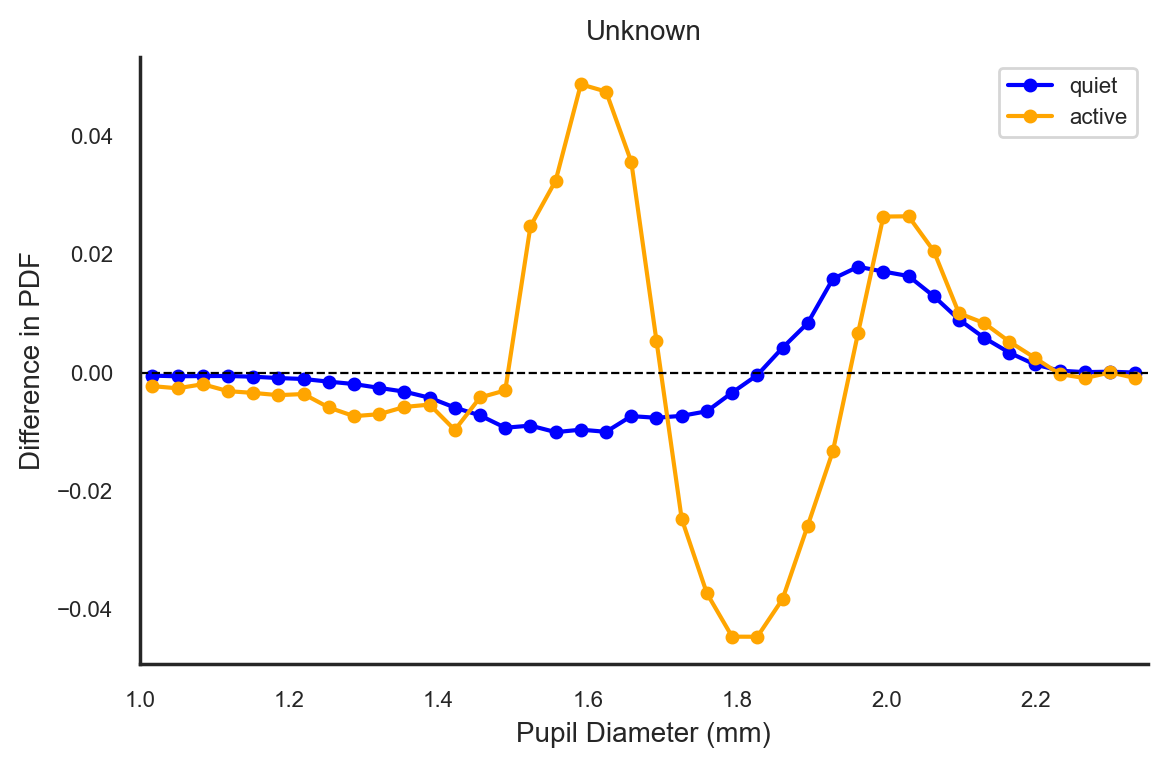

In [60]:
plot_difference_by_animal(block_collection,
                          export_path=None,
                          figsize=(6, 4))


In [52]:
last_ts = []
for block in block_collection:
    last_t = block.left_eye_data.iloc[-1].ms_axis
    last_ts.append(last_t)

np.sum(np.array(last_ts))/1000/60/60

7.717610249999998

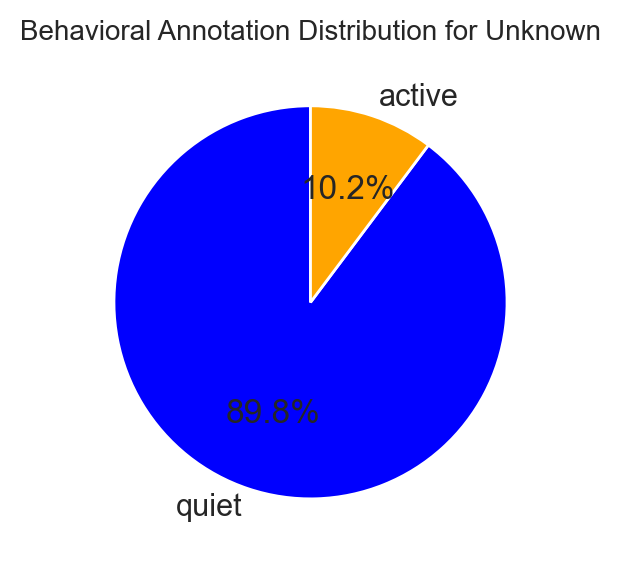

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Dictionary to hold total time per annotation for each animal
animal_annotation_time = {}

# Loop over blocks to accumulate total time per behavioral annotation
for block in block_collection:
    # Assuming each block has an attribute 'animal'
    animal = block.animal if hasattr(block, 'animal') else "Unknown"

    # Ensure the animal key exists
    if animal not in animal_annotation_time:
        animal_annotation_time[animal] = {'quiet': 0, 'active': 0}

    behavior_df = block.behavior_state.copy()
    # Ensure times are in milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Compute duration for each annotation period and accumulate
    for _, row in behavior_df.iterrows():
        annotation = row['annotation']
        if annotation not in ['quiet', 'active']:
            continue
        duration = row['end_time_ms'] - row['start_time_ms']
        animal_annotation_time[animal][annotation] += duration

# Plot a separate pie chart for each animal
for animal, time_dict in animal_annotation_time.items():
    labels = []
    sizes = []
    for state in ['quiet', 'active']:
        labels.append(state)
        sizes.append(time_dict[state])

    # Normalize to percentages
    total = sum(sizes)
    if total > 0:
        sizes = [s / total * 100 for s in sizes]

    fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['blue', 'orange'], startangle=90)
    ax.set_title(f'Behavioral Annotation Distribution for {animal}', fontsize=10)
    plt.tight_layout()
    plt.show()


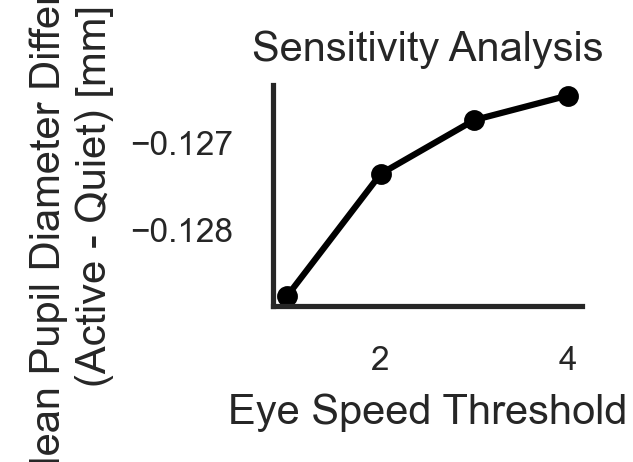

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

thresholds = [1, 2, 3, 4]
difference_means = []

# Loop over each threshold value
for thr in thresholds:
    aggregated = {'quiet': [], 'active': []}

    # Loop over blocks
    for block in block_collection:
        behavior_df = block.behavior_state.copy()
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Filter eye data based on the current threshold
        left_filtered = block.left_eye_data.query('speed_r < @thr')
        right_filtered = block.right_eye_data.query('speed_r < @thr')

        for _, row in behavior_df.iterrows():
            annotation = row['annotation']
            if annotation not in ['quiet', 'active']:
                continue
            start_ms = row['start_time_ms']
            end_ms = row['end_time_ms']

            left_vals = left_filtered.query('ms_axis > @start_ms and ms_axis < @end_ms')[
                'pupil_diameter'].dropna().tolist()
            right_vals = right_filtered.query('ms_axis >= @start_ms and ms_axis <= @end_ms')[
                'pupil_diameter'].dropna().tolist()
            aggregated[annotation].extend(left_vals)
            aggregated[annotation].extend(right_vals)

    # Compute mean pupil diameter for active and quiet states if data is available
    active_data = np.array(aggregated['active'])
    quiet_data = np.array(aggregated['quiet'])

    if len(active_data) > 0 and len(quiet_data) > 0:
        diff_mean = np.mean(active_data) - np.mean(quiet_data)
    else:
        diff_mean = np.nan  # In case data is missing
    difference_means.append(diff_mean)

# Plot sensitivity: threshold (x-axis) vs. mean difference (y-axis)
sns.set(style="white")
fig, ax = plt.subplots(figsize=(2.2, 1.7), dpi=300)
ax.plot(thresholds, difference_means, marker='o', linestyle='-', color='black', markersize=4)
ax.set_xlabel('Eye Speed Threshold', fontsize=10)
ax.set_ylabel('Mean Pupil Diameter Difference\n(Active - Quiet) [mm]', fontsize=10)
ax.set_title('Sensitivity Analysis', fontsize=10)
ax.tick_params(axis='both', which='both', labelsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.show()


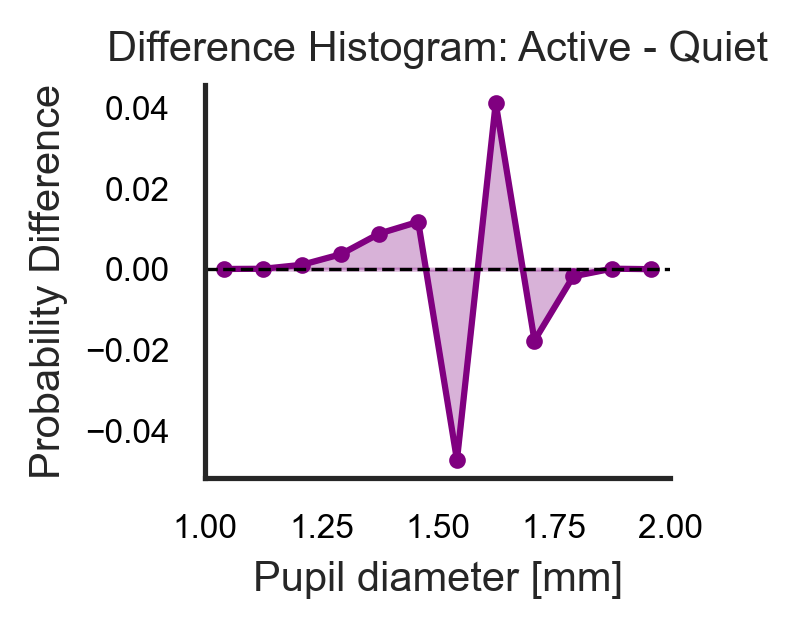

In [10]:
# subtracted graph version 1
import os
import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_difference_eye_probability_histogram(block_list, export_path=None, num_bins=40, 
                                                x_range=(1.25, 2.5), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save a Seaborn-based difference histogram representing the probability difference
    between active and quiet pupil diameter distributions (active - quiet). The area between the
    difference curve and 0 is shaded for visual clarity.

    Args:
        block_list: List of BlockSync objects with these attributes:
            - behavior_state (pd.DataFrame): with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Directory to save the output (folder is created automatically if None is provided).
        num_bins (int): Number of bins to use for pupil diameter values.
        x_range (tuple): The x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) for the central 98%).
    """
    # Initialize dictionary for annotation data and a list for overall data (for bin calculation)
    combined_aggregated = {}
    all_data = []
    
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Use provided times (assumed already in ms or convert if needed)
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Prepare keys in the aggregation dictionary
        for label in behavior_df['annotation'].unique():
            if label not in combined_aggregated:
                combined_aggregated[label] = []

        # Aggregate pupil diameter data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            left_vals = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_vals = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            combined_aggregated[annotation].extend(left_vals)
            combined_aggregated[annotation].extend(right_vals)
            all_data.extend(left_vals)
            all_data.extend(right_vals)

    # Determine shared bin edges using overall data and outlier limits
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Extract and filter data for 'active' and 'quiet' annotations
    active_data = np.array(combined_aggregated.get('active', []))
    quiet_data = np.array(combined_aggregated.get('quiet', []))
    active_data = active_data[(active_data >= outlier_min) & (active_data <= outlier_max)]
    quiet_data = quiet_data[(quiet_data >= outlier_min) & (quiet_data <= outlier_max)]

    # Compute histograms using the shared bin edges
    hist_active, _ = np.histogram(active_data, bins=bin_edges)
    hist_quiet, _ = np.histogram(quiet_data, bins=bin_edges)

    # Normalize to obtain probabilities
    total_active = np.sum(hist_active)
    total_quiet = np.sum(hist_quiet)
    prob_active = hist_active / total_active if total_active > 0 else hist_active
    prob_quiet = hist_quiet / total_quiet if total_quiet > 0 else hist_quiet

    # Compute the difference: active minus quiet
    diff = prob_active - prob_quiet

    # Calculate bin midpoints for plotting
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Set up the plot using Seaborn styling
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(2, 1.7), dpi=300)
    
    # Plot the difference curve with small dot markers
    ax.plot(bin_midpoints, diff, marker='o', markersize=3, linestyle='-', color='purple', label='Active - Quiet')
    # Shade the area between the curve and 0
    ax.fill_between(bin_midpoints, diff, 0, color='purple', alpha=0.3)
    # Add a dashed horizontal line at 0 for reference
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

    # Set title and labels with font size 10
    ax.set_title('Difference Histogram: Active - Quiet', fontsize=10)
    ax.set_xlabel('Pupil diameter [mm]', fontsize=10)
    ax.set_ylabel('Probability Difference', fontsize=10)
    
    # Configure tick parameters (font size 8)
    ax.tick_params(axis='both', labelsize=8)
    ax.tick_params(axis='both', direction='out', which='major', length=5, width=1, colors='black')
    ax.tick_params(axis='both', direction='out', which='minor', length=3, width=1, colors='black')
    
    # Remove top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Set x-axis limits
    ax.set_xlim(x_range)
    #ax.legend(loc='upper right', fontsize=8)

    # Export the plot and data if an export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_difference_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        pdf_file = os.path.join(full_export_path, "pupil_diameter_difference.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        data_file = os.path.join(full_export_path, "difference_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(diff, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

plot_difference_eye_probability_histogram(block_collection[5:6], export_path=None, num_bins=12, x_range=(1, 2))

In [9]:
block_collection[5:6]

[BlockSync object for animal PV_57 with 
 block_num 012 at date PV_57_hunter_2_2024-12-01_16-08-39]

Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_between animals\pupil_diameter_diff_comparison_2025_02_26_13_32_52


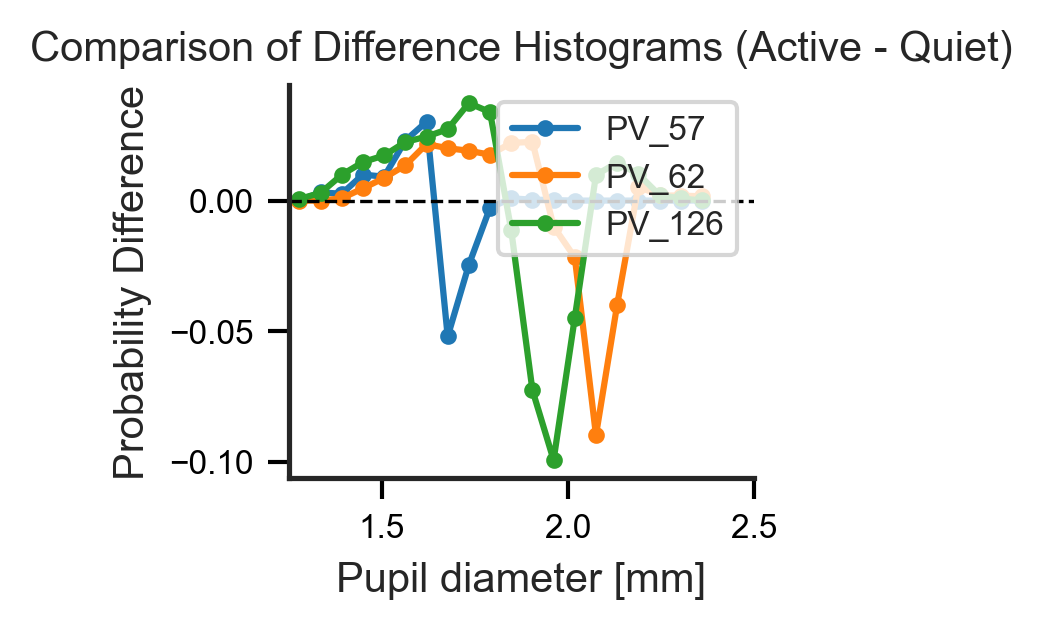

In [17]:

def compare_animals_difference_histogram(block_dict, export_path=None, num_bins=40, 
                                           x_range=(1.25, 2.5), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save a comparison graph of difference histograms (active - quiet) for multiple animals.
    The block_dict keys include an animal identifier (formatted as 'PV_x', where x is one to three digits)
    and a block identifier (e.g., 'PV_62_block_023'). Blocks are grouped by animal, and for each animal,
    pupil diameter data for 'active' and 'quiet' annotations are aggregated across blocks. A normalized
    difference histogram (active - quiet) is computed using shared bin edges and plotted on a single graph.
    
    Args:
        block_dict (dict): Dictionary where each key is a string containing the animal identifier (e.g., 'PV_62_block_023')
                           and the value is a block object. Each block must have:
                                - behavior_state (pd.DataFrame): with columns 'start_time', 'end_time', and 'annotation'.
                                - left_eye_data (pd.DataFrame): with columns 'ms_axis' and 'pupil_diameter'.
                                - right_eye_data (pd.DataFrame): with columns 'ms_axis' and 'pupil_diameter'.
        export_path (str): Directory to save the output plot and data. A timestamped folder is created if provided.
        num_bins (int): Number of bins for the pupil diameter values.
        x_range (tuple): x-axis range (min, max) for the plot.
        outlier_percentiles (tuple): Percentile range for outlier removal (e.g., (0.001, 99.999)).
    """
    overall_data = []
    animal_data = {}  # Dictionary to store aggregated data per animal
    
    # Process each block; extract animal name from the key (assumes format 'PV_x_block_YYY')
    for key, block in block_dict.items():
        # Extract animal name (e.g., "PV_62") using a regex or split method
        match = re.match(r'^(PV_\d+)', key)
        if not match:
            continue  # Skip if the key does not contain the expected animal identifier
        animal = match.group(1)
        if animal not in animal_data:
            animal_data[animal] = {'active': [], 'quiet': []}
        
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Assume times are already in milliseconds; if not, convert accordingly.
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']
        
        # Aggregate pupil diameter data for the 'active' and 'quiet' annotations
        for _, row in behavior_df.iterrows():
            annotation = row['annotation']
            if annotation not in ['active', 'quiet']:
                continue
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            left_vals = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')["pupil_diameter"].dropna()
            right_vals = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')["pupil_diameter"].dropna()
            
            animal_data[animal][annotation].extend(left_vals)
            animal_data[animal][annotation].extend(right_vals)
            
            # Also aggregate for overall bin edge determination
            overall_data.extend(left_vals)
            overall_data.extend(right_vals)
    
    # Compute outlier limits and shared bin edges
    outlier_min, outlier_max = np.percentile(overall_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Prepare a color palette (one color per animal)
    colors = sns.color_palette('tab10', n_colors=len(animal_data))
    
    animal_diffs = {}
    for idx, (animal, data_dict) in enumerate(animal_data.items()):
        # Filter data to remove outliers
        active_data = np.array(data_dict['active'])
        quiet_data = np.array(data_dict['quiet'])
        active_data = active_data[(active_data >= outlier_min) & (active_data <= outlier_max)]
        quiet_data = quiet_data[(quiet_data >= outlier_min) & (quiet_data <= outlier_max)]
        
        # Compute histograms using shared bin edges
        hist_active, _ = np.histogram(active_data, bins=bin_edges)
        hist_quiet, _ = np.histogram(quiet_data, bins=bin_edges)
        
        # Normalize to probabilities
        total_active = np.sum(hist_active)
        total_quiet = np.sum(hist_quiet)
        prob_active = hist_active / total_active if total_active > 0 else hist_active
        prob_quiet = hist_quiet / total_quiet if total_quiet > 0 else hist_quiet
        
        # Compute the difference (active - quiet)
        diff = prob_active - prob_quiet
        animal_diffs[animal] = diff
    
    # Create the comparison plot
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(2, 1.7), dpi=300)
    
    # Plot each animal's difference curve with small markers and shade the area between the curve and 0
    for idx, (animal, diff) in enumerate(animal_diffs.items()):
        ax.plot(bin_midpoints, diff, marker='o', markersize=3, linestyle='-', color=colors[idx], label=animal)
        #ax.fill_between(bin_midpoints, diff, 0, color=colors[idx], alpha=0.3)
    
    # Add a horizontal dashed reference line at 0
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    
    # Set title and axis labels with the specified font sizes
    ax.set_title('Comparison of Difference Histograms (Active - Quiet)', fontsize=10)
    ax.set_xlabel('Pupil diameter [mm]', fontsize=10)
    ax.set_ylabel('Probability Difference', fontsize=10)
    
    # Configure tick parameters
    ax.tick_params(axis='both', which='both', bottom=True, left=True)

    ax.tick_params(axis='both', labelsize=8)
    ax.tick_params(axis='both', direction='out', which='major', length=5, width=1, colors='black')
    ax.tick_params(axis='both', direction='out', which='minor', length=3, width=1, colors='black')
    
    # Remove top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)
    
    # Optionally export the plot and data if an export path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_diff_comparison_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        
        pdf_file = os.path.join(full_export_path, "pupil_diameter_diff_comparison.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        
        data_file = os.path.join(full_export_path, "animal_diff_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(animal_diffs, f)
        
        print(f"Exported plot and data to: {full_export_path}")
    
    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_between animals'
compare_animals_difference_histogram(block_dict, export_path=export_path, num_bins=20, 
                                           x_range=(1.25, 2.5), outlier_percentiles=(0.005, 99.995))

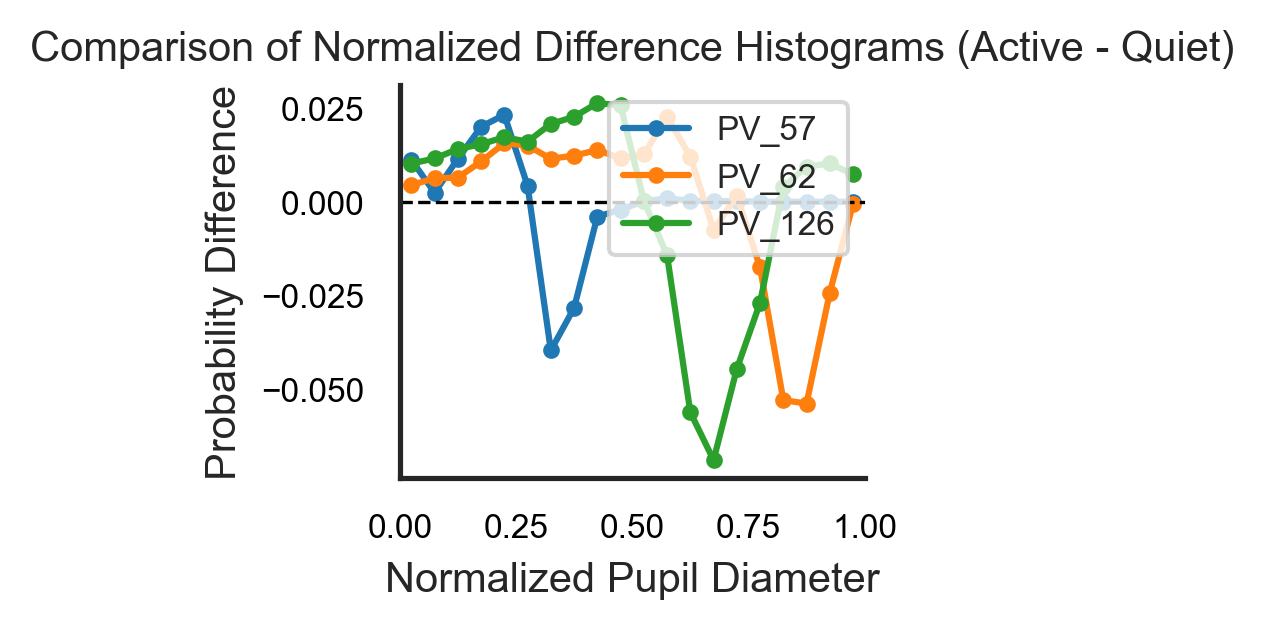

In [16]:
def compare_animals_difference_histogram_normalized(block_dict, export_path=None, num_bins=40, 
                                                    x_range=(0, 1), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save a comparison graph of difference histograms (active - quiet) for multiple animals,
    with each animal’s pupil diameter values normalized to [0, 1] based on its own distribution
    (after outlier removal). This allows for a fair comparison even when animals have different
    absolute pupil diameter ranges.
    
    Args:
        block_dict (dict): Dictionary where each key is a string containing the animal identifier (e.g., 'PV_62_block_023')
                           and the value is a block object. Each block must have:
                                - behavior_state (pd.DataFrame): with columns 'start_time', 'end_time', and 'annotation'.
                                - left_eye_data (pd.DataFrame): with columns 'ms_axis' and 'pupil_diameter'.
                                - right_eye_data (pd.DataFrame): with columns 'ms_axis' and 'pupil_diameter'.
        export_path (str): Directory to save the output plot and data.
        num_bins (int): Number of bins for the normalized pupil diameter values.
        x_range (tuple): x-axis range for the plot; default is (0, 1) since data are normalized.
        outlier_percentiles (tuple): Percentile range for outlier removal.
    """
    overall_data = []
    animal_data = {}  # Dictionary to store aggregated raw data per animal

    # Process each block; extract animal name from the key (assumes format 'PV_x_block_YYY')
    for key, block in block_dict.items():
        # Extract animal name (e.g., "PV_62") using regex
        match = re.match(r'^(PV_\d+)', key)
        if not match:
            continue
        animal = match.group(1)
        if animal not in animal_data:
            animal_data[animal] = {'active': [], 'quiet': []}

        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Assume times are already in milliseconds.
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Aggregate pupil diameter data for 'active' and 'quiet' annotations
        for _, row in behavior_df.iterrows():
            annotation = row['annotation']
            if annotation not in ['active', 'quiet']:
                continue
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            left_vals = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')["pupil_diameter"].dropna()
            right_vals = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')["pupil_diameter"].dropna()

            animal_data[animal][annotation].extend(left_vals)
            animal_data[animal][annotation].extend(right_vals)

            # Also aggregate for overall bin edge determination (global outlier removal)
            overall_data.extend(left_vals)
            overall_data.extend(right_vals)

    # Compute global outlier limits using overall data (this is done prior to normalization)
    outlier_min, outlier_max = np.percentile(overall_data, outlier_percentiles)

    # Prepare a color palette (one color per animal)
    colors = sns.color_palette('tab10', n_colors=len(animal_data))
    
    animal_diffs = {}
    # Here we now compute shared bin edges for normalized data: they always span 0 to 1.
    bin_edges = np.linspace(x_range[0], x_range[1], num_bins + 1)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    for idx, (animal, data_dict) in enumerate(animal_data.items()):
        # Filter each animal's data to remove outliers (using global limits)
        active_data = np.array(data_dict['active'])
        quiet_data = np.array(data_dict['quiet'])
        active_data = active_data[(active_data >= outlier_min) & (active_data <= outlier_max)]
        quiet_data = quiet_data[(quiet_data >= outlier_min) & (quiet_data <= outlier_max)]

        # Combine active and quiet data to get the animal-specific min and max
        combined = np.concatenate((active_data, quiet_data))
        if combined.size == 0:
            continue  # Skip if no data remains after outlier removal

        animal_min = combined.min()
        animal_max = combined.max()
        # Normalize data to the [0, 1] range using animal-specific min and max.
        active_norm = (active_data - animal_min) / (animal_max - animal_min)
        quiet_norm = (quiet_data - animal_min) / (animal_max - animal_min)

        # Compute histograms on the normalized data using the same bin edges for both conditions.
        hist_active, _ = np.histogram(active_norm, bins=bin_edges)
        hist_quiet, _ = np.histogram(quiet_norm, bins=bin_edges)

        # Normalize the histograms to probabilities
        total_active = np.sum(hist_active)
        total_quiet = np.sum(hist_quiet)
        prob_active = hist_active / total_active if total_active > 0 else hist_active
        prob_quiet = hist_quiet / total_quiet if total_quiet > 0 else hist_quiet

        # Compute the difference (active - quiet)
        diff = prob_active - prob_quiet
        animal_diffs[animal] = diff

    # Create the comparison plot
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(2, 1.7), dpi=300)

    # Plot each animal's difference curve with markers and a horizontal reference line at 0.
    for idx, (animal, diff) in enumerate(animal_diffs.items()):
        ax.plot(bin_midpoints, diff, marker='o', markersize=3, linestyle='-', color=colors[idx], label=animal)
        # Optionally: ax.fill_between(bin_midpoints, diff, 0, color=colors[idx], alpha=0.3)

    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title('Comparison of Normalized Difference Histograms (Active - Quiet)', fontsize=10)
    ax.set_xlabel('Normalized Pupil Diameter', fontsize=10)
    ax.set_ylabel('Probability Difference', fontsize=10)

    ax.tick_params(axis='both', which='both', labelsize=8, direction='out', length=5, width=1, colors='black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)

    # Optionally export the plot and data if an export path is provided.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"normalized_pupil_diameter_diff_comparison_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        pdf_file = os.path.join(full_export_path, "normalized_pupil_diameter_diff_comparison.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        data_file = os.path.join(full_export_path, "animal_diff_data_normalized.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(animal_diffs, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
compare_animals_difference_histogram_normalized(block_dict, export_path=None, num_bins=20, 
                                           x_range=(0, 1), outlier_percentiles=(1, 99))

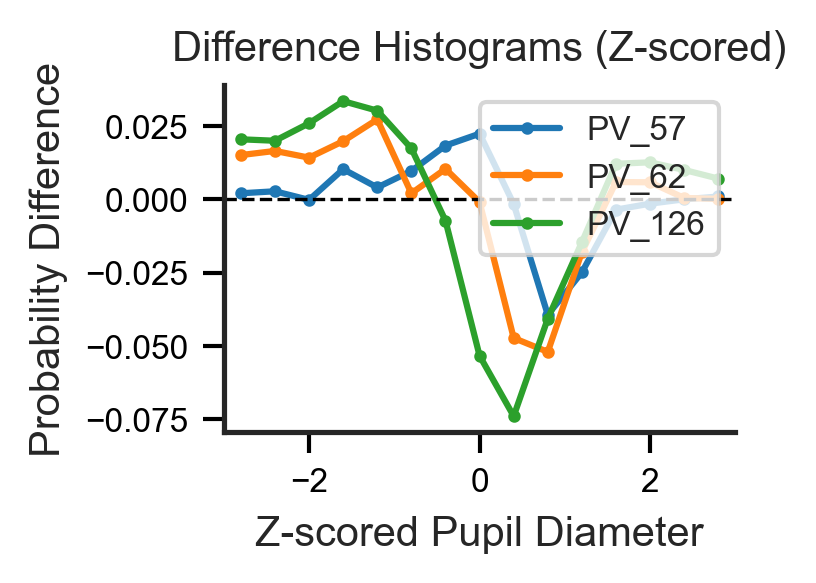

In [18]:
def compare_animals_difference_histogram_zscore(block_dict, export_path=None, num_bins=40, 
                                                  x_range=(-3, 3), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save a comparison graph of difference histograms (active - quiet) for multiple animals,
    with pupil diameter values normalized by z-scoring (subtracting the mean and dividing by the standard deviation).
    
    Outlier removal is performed using global percentiles. Then, for each animal the combined active and quiet data 
    (after dropping NaNs) are z-scored. Shared histogram bin edges are used on the z-scored data for plotting.
    
    Args:
        block_dict (dict): Dictionary where keys include an animal identifier (e.g., 'PV_62_block_023') and 
                           values are block objects with the necessary dataframes.
        export_path (str): Directory to save the output plot and data.
        num_bins (int): Number of bins for the z-scored pupil diameter values.
        x_range (tuple): Range for the x-axis in the z-scored space (default is (-3, 3)).
        outlier_percentiles (tuple): Percentile range for global outlier removal.
    """
    import re, os, datetime, pickle
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    overall_data = []
    animal_data = {}  # Aggregate raw data per animal

    # Process each block
    for key, block in block_dict.items():
        match = re.match(r'^(PV_\d+)', key)
        if not match:
            continue
        animal = match.group(1)
        if animal not in animal_data:
            animal_data[animal] = {'active': [], 'quiet': []}
        
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Assume times are in milliseconds already.
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        for _, row in behavior_df.iterrows():
            annotation = row['annotation']
            if annotation not in ['active', 'quiet']:
                continue
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            # Drop NaNs during extraction
            left_vals = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')["pupil_diameter"].dropna().values
            right_vals = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')["pupil_diameter"].dropna().values

            animal_data[animal][annotation].extend(left_vals)
            animal_data[animal][annotation].extend(right_vals)

            overall_data.extend(left_vals)
            overall_data.extend(right_vals)

    overall_data = np.array(overall_data)
    # Compute global outlier limits
    outlier_min, outlier_max = np.percentile(overall_data, outlier_percentiles)

    # Prepare plotting
    colors = sns.color_palette('tab10', n_colors=len(animal_data))
    animal_diffs = {}
    bin_edges = np.linspace(x_range[0], x_range[1], num_bins + 1)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Process per animal
    for idx, (animal, data_dict) in enumerate(animal_data.items()):
        active_data = np.array(data_dict['active'])
        quiet_data = np.array(data_dict['quiet'])
        # Remove outliers based on global limits
        active_data = active_data[(active_data >= outlier_min) & (active_data <= outlier_max)]
        quiet_data = quiet_data[(quiet_data >= outlier_min) & (quiet_data <= outlier_max)]

        # Combine active and quiet data to calculate mean and std (NaNs already dropped)
        combined = np.concatenate((active_data, quiet_data))
        if combined.size == 0:
            continue
        mean_val = np.nanmean(combined)
        std_val = np.nanstd(combined)
        # Avoid division by zero
        if std_val == 0:
            std_val = 1.0

        # Z-score transformation
        active_z = (active_data - mean_val) / std_val
        quiet_z = (quiet_data - mean_val) / std_val

        # Compute histograms on the z-scored data
        hist_active, _ = np.histogram(active_z, bins=bin_edges)
        hist_quiet, _ = np.histogram(quiet_z, bins=bin_edges)
        total_active = np.sum(hist_active)
        total_quiet = np.sum(hist_quiet)
        prob_active = hist_active / total_active if total_active > 0 else hist_active
        prob_quiet = hist_quiet / total_quiet if total_quiet > 0 else hist_quiet

        # Difference (active - quiet)
        diff = prob_active - prob_quiet
        animal_diffs[animal] = diff

    # Create the plot
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(2.2, 1.5), dpi=300)
    for idx, (animal, diff) in enumerate(animal_diffs.items()):
        ax.plot(bin_midpoints, diff, marker='o', markersize=2, linestyle='-', color=colors[idx], label=animal)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title('Difference Histograms (Z-scored)', fontsize=10)
    ax.set_xlabel('Z-scored Pupil Diameter', fontsize=10)
    ax.set_ylabel('Probability Difference', fontsize=10)
    # Configure tick parameters
    ax.tick_params(axis='both', which='both', bottom=True, left=True)

    ax.tick_params(axis='both', labelsize=8)
    ax.tick_params(axis='both', direction='out', which='major', length=5, width=1, colors='black')
    ax.tick_params(axis='both', direction='out', which='minor', length=3, width=1, colors='black')
    
    # Remove top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)
    
    
    
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_diff_comparison_zscore_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "pupil_diameter_diff_comparison_zscore.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "animal_diff_data_zscore.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(animal_diffs, f)
        print(f"Exported plot and data to: {full_export_path}")
    plt.show()

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_between animals'
compare_animals_difference_histogram_zscore(block_dict, export_path=None, num_bins=15, 
                                                  x_range=(-3, 3), outlier_percentiles=(0.1, 99.9))

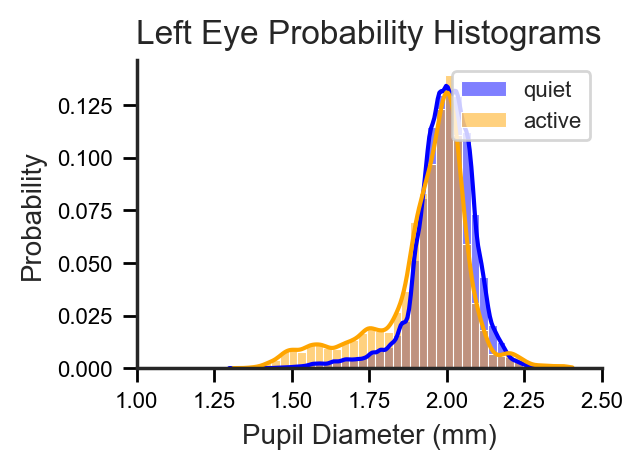

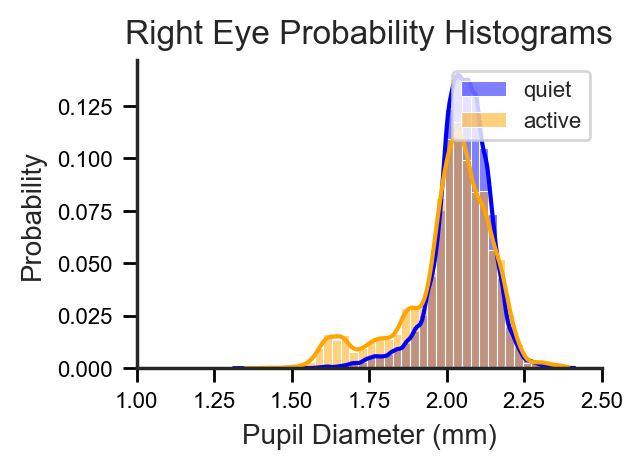

In [26]:
def plot_split_eye_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15),
                                          outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Separates data
    into two plots: one for the left eye and one for the right eye.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the output (folder created automatically if None is provided).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')[
                'pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')[
                'pupil_diameter'].dropna()

            # Add data to respective dictionaries
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot for left eye
    fig_left, ax_left = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in left_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'), kde=True,
            ax=ax_left,
        )
    ax_left.set_title('Left Eye Probability Histograms', fontsize=12)
    ax_left.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax_left.set_ylabel('Probability', fontsize=10)
    ax_left.tick_params(axis='both', labelsize=8)
    ax_left.spines['right'].set_visible(False)
    ax_left.spines['top'].set_visible(False)
    ax_left.tick_params(axis='both', direction='out', which='major', length=5, width=1, colors='black', bottom=True,
                        left=True)
    ax_left.tick_params(axis='both', direction='out', which='minor', length=5, width=1, colors='black', bottom=True,
                        left=True)
    ax_left.set_xlim(x_range)
    ax_left.legend(loc='upper right', fontsize=8)

    # Plot for right eye
    fig_right, ax_right = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in right_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'), kde=True,
            ax=ax_right,
        )

    ax_right.set_title('Right Eye Probability Histograms', fontsize=12)
    ax_right.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax_right.set_ylabel('Probability', fontsize=10)
    ax_right.tick_params(axis='both', labelsize=8)
    ax_right.spines['right'].set_visible(False)
    ax_right.spines['top'].set_visible(False)
    ax_right.tick_params(axis='both', direction='out', which='major', length=5, width=1, colors='black', bottom=True,
                         left=True)
    ax_right.tick_params(axis='both', direction='out', which='minor', length=5, width=1, colors='black', bottom=True,
                         left=True)
    ax_right.set_xlim(x_range)
    ax_right.legend(loc='upper right', fontsize=8)

    # Export section
    if export_path is not None:
        # Create timestamped folder
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"split_eye_pupil_diameter_behavior_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save left eye plot
        pdf_file_left = os.path.join(full_export_path, "left_eye_pupil_vs_behavior.pdf")
        fig_left.savefig(pdf_file_left, format='pdf', bbox_inches='tight', dpi=300)

        # Save right eye plot
        pdf_file_right = os.path.join(full_export_path, "right_eye_pupil_vs_behavior.pdf")
        fig_right.savefig(pdf_file_right, format='pdf', bbox_inches='tight', dpi=300)

        # Save raw data
        data_file = os.path.join(full_export_path, "aggregated_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({'left_eye': left_eye_aggregated, 'right_eye': right_eye_aggregated}, f)

        print(f"Exported plots and data to: {full_export_path}")

    plt.show()


export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_split_pv62'
plot_split_eye_probability_histograms(block_collection, export_path=None, num_bins=40, x_range=(1, 2.5))